# **Rain Prediction Using Machine Learning**

The weather has a significant impact on many life aspects, one of which is agricultural industry and because of that, being able to predict it helps farmers in their day-to-day decisions such as how to plan efficiently, minimize costs and maximize yields. 

A major agricultural company needs to have an accurate rain prediction algorithm that will improve their decision-making on typical farming activities such as planting and irrigating. 

Using historical rain information from Australia regions in 10 years as research data, it is necessary to predict weather(rain) in next day.

**Objectives**
- What factors and conditions in current day that will cause rain in the next day?
- What machine learning algorithms are suitable for predicting rain in the next day?
- Where is the location that has the highest frequency of rain?
- What is the impact of the predictive model for business problems that operating in the agricultural sector?


**Dataset Informations**
- `Date`: The date of observation
- `Location`: The common name of the location of the weather station
- `MinTemp`: The minimum temperature in degrees celsius
- `MaxTemp`: The maximum temperature in degrees celsius
- `Rainfall`: The amount of rainfall recorded for the day in mm
- `Evaporation`: The so-called Class A pan evaporation (mm) in the 24 hours to 9am
- `Sunshine`: The number of hours of bright sunshine in the day
- `WindGustDir`: The direction of the strongest wind gust in the 24 hours to midnight
- `WindGustSpeed`: The speed (km/h) of the strongest wind gust in the 24 hours to midnight
- `WindDir9am`: Direction of the wind at 9am
- `WindDir3pm`: Direction of the wind at 3pm
- `WindSpeed9am`: Wind speed (km/hr) averaged over 10 minutes prior to 9am
- `WindSpeed3pm`: Wind speed (km/hr) averaged over 10 minutes prior to 3pm
- `Humidity9am`: Humidity (percent) at 9am
- `Humidity3pm`: Humidity (percent) at 3pm
- `Pressure9am`: Atmospheric pressure (hpa) reduced to mean sea level at 9am
- `Pressure3pm`: Atmospheric pressure (hpa) reduced to mean sea level at 3pm
- `Cloud9am`: Fraction of sky obscured by cloud at 9am (in Oktas)
- `Cloud3pm`: Fraction of sky obscured by cloud at 3pm (in Oktas)
- `Temp9am`: Temperature (degrees C) at 9am
- `Temp3pm`: Temperature (degrees C) at 3pm
- `RainToday`: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0 (Boolean)
- `RainTomorrow`: The amount of next day rain in mm (Boolean). A kind of measure of the "risk"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Data and Libraries**

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from statistics import mode
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')

In [ ]:
base_data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/weatherAUS.csv')
base_data.head(3)

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   

   RainTomorrow  
0            No  
1            No  
2            No  

[3 rows x 23 columns]

In [ ]:
# General info
base_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

- Dataset contains 22 features with 1 target `RainTomorrow` column.
- It looks like many columns have missing values.
- `Date` column will be converted to datetime format and will be changed become `Day`, `Month`, and `Year` columns.

# **Baseline Model**

First of all, I will to create model with low effort preprocessing, as baseline.

In [ ]:
# Convert Date column to datetime format
base_data['Date'] = pd.to_datetime(base_data['Date'])

# Create Day, Month, and Year column
base_data['Year'] = base_data['Date'].dt.year
base_data['Month'] = base_data['Date'].dt.month
base_data['Day'] = base_data['Date'].dt.day

In [ ]:
# Drop Date column from dataset
base_data = base_data.drop(columns = ['Date'])

In [ ]:
# Check ratio for missing values
base_data.isna().sum() * 100 / len(base_data)

Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
Year              0.000000
Month             0.000000
Day               0.000000
dtype: float64

I will impute all missing value with median value for numerical and mode for categorical.

In [ ]:
# Group data based on numericals and categoricals data
Numericals = [column_name for column_name in base_data.columns if base_data[column_name].dtype != 'O']
Categoricals = [column_name for column_name in base_data.columns if base_data[column_name].dtype == 'O']

In [ ]:
# Retrieve missing value in numerical columns
numerical_features_with_null = [feature for feature in Numericals if base_data[feature].isnull().sum()]
numerical_features_with_null

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [ ]:
# Fill missing value in numerical column with median value
for feature in numerical_features_with_null:
    median_value = base_data[feature].median()
    base_data[feature].fillna(median_value,inplace=True)

In [ ]:
# Retrieve missing value in categorical columns
categoricals_features_with_null = [feature for feature in Categoricals if base_data[feature].isnull().sum()]
categoricals_features_with_null

['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

In [ ]:
# Fill missing value with mode value
for feature in categoricals_features_with_null:
    mode_val = base_data[feature].mode()[0]
    base_data[feature].fillna(mode_val,inplace=True)

Now all missing value already imputed.

In [ ]:
# Duplicated data check
base_data.duplicated().sum()

0

For categorical column, I will transform to numeric, for 2 distinct value, I will transform to binary code, and for others one hot encoding.

In [ ]:
# Categorical with 2 distinct values -> Binary Code
base_data['RainTomorrow'] = base_data['RainTomorrow'].apply(lambda x: 1 if x=='Yes' else 0).astype(int)
base_data['RainToday'] = base_data['RainToday'].apply(lambda x: 1 if x=='Yes' else 0).astype(int)

In [ ]:
# Categorical with other distinct values -> One Hot Encoding
base_data = pd.get_dummies(base_data)
base_data.head(3)

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0     13.4     22.9       0.6          4.8       8.4           44.0   
1      7.4     25.1       0.0          4.8       8.4           44.0   
2     12.9     25.7       0.0          4.8       8.4           46.0   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  WindDir3pm_NNW  \
0          20.0          24.0         71.0         22.0  ...               0   
1           4.0          22.0         44.0         25.0  ...               0   
2          19.0          26.0         38.0         30.0  ...               0   

   WindDir3pm_NW  WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  \
0              0             0              0               0               0   
1              0             0              0               0               0   
2              0             0              0               0               0   

   WindDir3pm_SW  WindDir3pm_W  WindDir3pm_WNW  WindDir3pm_WSW  
0              0             0               1               0  
1              0             0               0               1  
2              0             0               0               1  

[3 rows x 118 columns]

In [ ]:
# Split train and test data into 80:20 proportion
train_data, test_data = train_test_split(base_data, test_size=0.20, random_state=42)
x_train = train_data.drop(columns='RainTomorrow')
x_test = test_data.drop(columns='RainTomorrow')

y_train = train_data['RainTomorrow']
y_test = test_data['RainTomorrow']

In [ ]:
models = [KNeighborsClassifier(),
          LogisticRegression(random_state=42),
          DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(random_state=42),
          XGBClassifier(random_state=42)]

baseline = pd.DataFrame(columns = ['Model', 'Accuracy', 'ROC_AUC'])

In [ ]:
for model in models:
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)

  model = str(type(model)).split('.')[-1][:-2]

  # accuracy
  accuracy = accuracy_score(y_test, y_pred)

  # ROC AUC
  roc_auc = roc_auc_score(y_test, y_pred)

  baseline = baseline.append({'Model': model,
                    'Accuracy': accuracy,
                    'ROC_AUC': roc_auc},
                     ignore_index=True)

In [ ]:
baseline

Model  Accuracy   ROC_AUC
0    KNeighborsClassifier  0.833597  0.708057
1      LogisticRegression  0.838065  0.700093
2  DecisionTreeClassifier  0.788980  0.696571
3  RandomForestClassifier  0.851952  0.716205
4           XGBClassifier  0.847140  0.713006

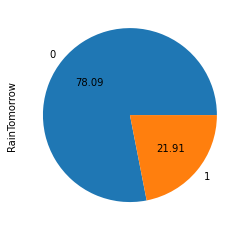

In [ ]:
# Check proportion of data
base_data['RainTomorrow'].value_counts().plot.pie(autopct='%.2f')

- Since the data imbalance, accuracy can't be used as evaluation metric. I use ROC curve and AUC score instead.
- I think the performance it's good enough as baseline, although the model performance still can be improved a lot.
- I will do EDA & feature engineering for trying to increase model performaces

# **Data Preprocessing**

## **Data Preparation**

In [ ]:
# Reload dataset
data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/weatherAUS.csv')

In [ ]:
# Convert Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Create Day, Month, and Year column
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

In [ ]:
# Drop Date column from dataset
data = data.drop(columns = ['Date'])

In [ ]:
# Reorder column position
data.insert(1, 'Month', (data.pop('Month')))
data.insert(2, 'Year', (data.pop('Year')))
data.insert(3, 'Day', (data.pop('Day')))

In [ ]:
data.head(3)

Location  Month  Year  Day  MinTemp  MaxTemp  Rainfall  Evaporation  \
0   Albury     12  2008    1     13.4     22.9       0.6          NaN   
1   Albury     12  2008    2      7.4     25.1       0.0          NaN   
2   Albury     12  2008    3     12.9     25.7       0.0          NaN   

   Sunshine WindGustDir  ...  Humidity9am Humidity3pm Pressure9am  \
0       NaN           W  ...         71.0        22.0      1007.7   
1       NaN         WNW  ...         44.0        25.0      1010.6   
2       NaN         WSW  ...         38.0        30.0      1007.6   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0       1007.1       8.0       NaN     16.9     21.8         No            No  
1       1007.8       NaN       NaN     17.2     24.3         No            No  
2       1008.7       NaN       2.0     21.0     23.2         No            No  

[3 rows x 25 columns]

## **Handling Missing Value**

For missing values handling, it needs some special treatment for handle missing values in this dataset.
- There are some features in certains locations that values is completely missing in 10 years observation. I need to drop these locations.
- Since this is rain situation, it will be little frail for modelling if I immediately impute the missing value with overall median and mode since weather condition in each location in every month is different. I will impute missing value based on `Location` and `Month`.

In [ ]:
# Filter and drop locations that have some features values is completely missing in 10 years observation
filter = data['Location'].isin(['Nhil', 'PearceRAAF', 'Penrith', 'Richmond', 
                              'SalmonGums', 'Tuggeranong', 'Uluru', 'Walpole', 
                              'Witchcliffe', 'Wollongong', 'NorahHead', 'Newcastle',
                              'Albany', 'MountGinini', 'Albury', 'BadgerysCreek', 
                              'Ballarat', 'Bendigo', 'GoldCoast', 'Katherine', 'Launceston',
                              'Adelaide', 'Dartmoor'])
data = data[~filter]

In [ ]:
data['Location'].value_counts()

Canberra            3436
Sydney              3344
Darwin              3193
Brisbane            3193
Hobart              3193
Perth               3193
Melbourne           3193
AliceSprings        3040
MountGambier        3040
Townsville          3040
Cairns              3040
PerthAirport        3009
Woomera             3009
Nuriootpa           3009
Cobar               3009
Watsonia            3009
CoffsHarbour        3009
Mildura             3009
MelbourneAirport    3009
Sale                3009
Williamtown         3009
WaggaWagga          3009
SydneyAirport       3009
NorfolkIsland       3009
Moree               3009
Portland            3009
Name: Location, dtype: int64

I will split train and test data into 80:20 proportion and fully explore the train data. For missing value in test data will impute based on all values in train data.

In [ ]:
# Split train and test data into 80:20 proportion
train_data, test_data = train_test_split(data, test_size=0.20, random_state=42)

In [ ]:
# Sort dataframe based on Location and Month for train and test data
train_data = (train_data.sort_values(['Location', 'Month'], ascending=[True, True])).reset_index()
test_data = (test_data.sort_values(['Location', 'Month'], ascending=[True, True])).reset_index()
train_data = train_data.drop(columns = ['index'])
test_data = test_data.drop(columns = ['index'])

In [ ]:
train_data.head(3)

Location  Month  Year  Day  MinTemp  MaxTemp  Rainfall  Evaporation  \
0  AliceSprings      1  2014   20     22.4     31.2       0.6          0.8   
1  AliceSprings      1  2010   26     21.3     40.6       0.0         13.4   
2  AliceSprings      1  2017   13     27.2     37.4       0.0         11.6   

   Sunshine WindGustDir  ...  Humidity9am Humidity3pm Pressure9am  \
0       1.6         ESE  ...         60.0        41.0      1006.7   
1      12.8         ESE  ...         17.0        10.0      1006.2   
2       NaN          SE  ...         57.0        54.0      1004.5   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0       1004.7       7.0       8.0     26.9     30.7         No            No  
1       1003.2       4.0       5.0     32.7     40.1         No            No  
2       1001.8       NaN       1.0     31.7     31.8         No           Yes  

[3 rows x 25 columns]

In [ ]:
test_data.head(3)

Location  Month  Year  Day  MinTemp  MaxTemp  Rainfall  Evaporation  \
0  AliceSprings      1  2015   14     21.4     31.3       0.0          7.2   
1  AliceSprings      1  2013   31     14.9     36.3       0.0         12.0   
2  AliceSprings      1  2009   16     25.7     37.5       0.0         22.6   

   Sunshine WindGustDir  ...  Humidity9am Humidity3pm Pressure9am  \
0      11.3          SE  ...         48.0        29.0      1009.6   
1      13.0          SW  ...         13.0         6.0      1013.6   
2      12.6         ESE  ...         15.0        14.0      1012.6   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0       1007.3       5.0       3.0     25.2     29.9         No            No  
1       1010.1       0.0       0.0     28.1     35.4         No           Yes  
2       1009.0       1.0       2.0     30.1     37.5         No            No  

[3 rows x 25 columns]

In [ ]:
# Identify numerical and categorical columns
Numericals = [column_name for column_name in train_data.columns if data[column_name].dtype != 'O']
Categoricals = [column_name for column_name in train_data.columns if data[column_name].dtype == 'O']

In [ ]:
Numericals

['Month',
 'Year',
 'Day',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [ ]:
Categoricals

['Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

For numerical columns I will impute median, categorical columns impute mode. For `Cloud9am` and `Cloud3pm` I will impute with mode since the columns have discrete values.

In [ ]:
# Identify median value based on Location and Month column
medians = (train_data.groupby(['Location','Month'])[['Year', 'Day', 'MinTemp', 
                                                     'MaxTemp', 'Rainfall', 'Evaporation', 
                                                     'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 
                                                     'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 
                                                     'Pressure9am', 'Pressure3pm', 'Temp9am', 
                                                     'Temp3pm']].agg('median').reset_index()).sort_values(['Location', 'Month'], ascending=[True, True])

medians.head(3)

Location  Month    Year   Day  MinTemp  MaxTemp  Rainfall  Evaporation  \
0  AliceSprings      1  2013.0  16.0    22.05     36.7       0.0         13.2   
1  AliceSprings      2  2014.0  15.0    20.45     36.1       0.0         12.4   
2  AliceSprings      3  2013.0  15.0    18.40     34.3       0.0         10.4   

   Sunshine  WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  \
0     12.00           44.0          19.0          19.5         33.0   
1     11.75           44.0          17.0          20.0         31.0   
2     11.10           39.0          15.0          19.0         34.0   

   Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  
0         21.0      1008.10      1004.70    29.70    35.15  
1         18.0      1010.85      1006.85    28.25    34.80  
2         19.0      1013.20      1009.60    26.20    32.90

In [ ]:
# Identify mode value based on Location and Month column
mode = (train_data.groupby(['Location','Month'])[['WindGustDir', 'WindDir9am', 
                                                  'WindDir3pm', 'Cloud9am', 
                                                  'Cloud3pm','RainToday', 
                                                  'RainTomorrow']].agg(lambda x: pd.Series.mode(x)[0]).reset_index()).sort_values(['Location', 'Month'], ascending=[True, True])

mode.head(3)

Location  Month WindGustDir WindDir9am WindDir3pm  Cloud9am  Cloud3pm  \
0  AliceSprings      1          SE          E        ESE       1.0       7.0   
1  AliceSprings      2          SE         SE         SE       0.0       1.0   
2  AliceSprings      3         ESE        ESE        ESE       1.0       1.0   

  RainToday RainTomorrow  
0        No           No  
1        No           No  
2        No           No

In [ ]:
# Concate median and mode
mode = mode.drop(columns = ['Location','Month'])

dummy = pd.concat([medians, mode], axis=1)

In [ ]:
# Reorder column position
dummy.insert(9, 'WindGustDir', (dummy.pop('WindGustDir')))
dummy.insert(11, 'WindDir9am', (dummy.pop('WindDir9am')))
dummy.insert(12, 'WindDir3pm', (dummy.pop('WindDir3pm')))
dummy.insert(19, 'Cloud9am', (dummy.pop('Cloud9am')))
dummy.insert(20, 'Cloud3pm', (dummy.pop('Cloud3pm')))
dummy.insert(23, 'RainToday', (dummy.pop('RainToday')))
dummy.insert(24, 'RainTomorrow', (dummy.pop('RainTomorrow')))

In [ ]:
# Change data type for Year and Day
dummy['Year'] = dummy['Year'].astype(int)
dummy['Day'] = dummy['Day'].astype(int)

In [ ]:
dummy.head(3)

Location  Month  Year  Day  MinTemp  MaxTemp  Rainfall  Evaporation  \
0  AliceSprings      1  2013   16    22.05     36.7       0.0         13.2   
1  AliceSprings      2  2014   15    20.45     36.1       0.0         12.4   
2  AliceSprings      3  2013   15    18.40     34.3       0.0         10.4   

   Sunshine WindGustDir  ...  Humidity9am Humidity3pm Pressure9am  \
0     12.00          SE  ...         33.0        21.0     1008.10   
1     11.75          SE  ...         31.0        18.0     1010.85   
2     11.10         ESE  ...         34.0        19.0     1013.20   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0      1004.70       1.0       7.0    29.70    35.15         No            No  
1      1006.85       0.0       1.0    28.25    34.80         No            No  
2      1009.60       1.0       1.0    26.20    32.90         No            No  

[3 rows x 25 columns]

In [ ]:
train_data.head(3)

Location  Month  Year  Day  MinTemp  MaxTemp  Rainfall  Evaporation  \
0  AliceSprings      1  2014   20     22.4     31.2       0.6          0.8   
1  AliceSprings      1  2010   26     21.3     40.6       0.0         13.4   
2  AliceSprings      1  2017   13     27.2     37.4       0.0         11.6   

   Sunshine WindGustDir  ...  Humidity9am Humidity3pm Pressure9am  \
0       1.6         ESE  ...         60.0        41.0      1006.7   
1      12.8         ESE  ...         17.0        10.0      1006.2   
2       NaN          SE  ...         57.0        54.0      1004.5   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0       1004.7       7.0       8.0     26.9     30.7         No            No  
1       1003.2       4.0       5.0     32.7     40.1         No            No  
2       1001.8       NaN       1.0     31.7     31.8         No           Yes  

[3 rows x 25 columns]

In [ ]:
test_data.head(3)

Location  Month  Year  Day  MinTemp  MaxTemp  Rainfall  Evaporation  \
0  AliceSprings      1  2015   14     21.4     31.3       0.0          7.2   
1  AliceSprings      1  2013   31     14.9     36.3       0.0         12.0   
2  AliceSprings      1  2009   16     25.7     37.5       0.0         22.6   

   Sunshine WindGustDir  ...  Humidity9am Humidity3pm Pressure9am  \
0      11.3          SE  ...         48.0        29.0      1009.6   
1      13.0          SW  ...         13.0         6.0      1013.6   
2      12.6         ESE  ...         15.0        14.0      1012.6   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0       1007.3       5.0       3.0     25.2     29.9         No            No  
1       1010.1       0.0       0.0     28.1     35.4         No           Yes  
2       1009.0       1.0       2.0     30.1     37.5         No            No  

[3 rows x 25 columns]

Now I will impute missing value in train and test data based on value each column in dummy.

In [ ]:
# Create Index
train_data['ID'] = train_data['Location'] + train_data['Month'].astype(str)
test_data['ID'] = test_data['Location'] + test_data['Month'].astype(str)
dummy['ID'] = dummy['Location'] + dummy['Month'].astype(str)

In [ ]:
# Move to first column
dummy.insert(0, 'ID', (dummy.pop('ID')))
train_data.insert(0, 'ID', (train_data.pop('ID')))
test_data.insert(0, 'ID', (test_data.pop('ID')))

In [ ]:
# Fill missing value in train and test data
train_data = (train_data.set_index('ID').combine_first(dummy.set_index('ID')).reset_index()).drop(columns = ['ID'])
test_data = (test_data.set_index('ID').combine_first(dummy.set_index('ID')).reset_index()).drop(columns = ['ID'])

In [ ]:
train_data.head(3)

Location  Month  Year  Day  MinTemp  MaxTemp  Rainfall  Evaporation  \
0  AliceSprings      1  2014   20     22.4     31.2       0.6          0.8   
1  AliceSprings      1  2010   26     21.3     40.6       0.0         13.4   
2  AliceSprings      1  2017   13     27.2     37.4       0.0         11.6   

   Sunshine WindGustDir  ...  Humidity9am Humidity3pm Pressure9am  \
0       1.6         ESE  ...         60.0        41.0      1006.7   
1      12.8         ESE  ...         17.0        10.0      1006.2   
2      12.0          SE  ...         57.0        54.0      1004.5   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0       1004.7       7.0       8.0     26.9     30.7         No            No  
1       1003.2       4.0       5.0     32.7     40.1         No            No  
2       1001.8       1.0       1.0     31.7     31.8         No           Yes  

[3 rows x 25 columns]

In [ ]:
test_data.head(3)

Location  Month  Year  Day  MinTemp  MaxTemp  Rainfall  Evaporation  \
0  AliceSprings      1  2015   14     21.4     31.3       0.0          7.2   
1  AliceSprings      1  2013   31     14.9     36.3       0.0         12.0   
2  AliceSprings      1  2009   16     25.7     37.5       0.0         22.6   

   Sunshine WindGustDir  ...  Humidity9am Humidity3pm Pressure9am  \
0      11.3          SE  ...         48.0        29.0      1009.6   
1      13.0          SW  ...         13.0         6.0      1013.6   
2      12.6         ESE  ...         15.0        14.0      1012.6   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0       1007.3       5.0       3.0     25.2     29.9         No            No  
1       1010.1       0.0       0.0     28.1     35.4         No           Yes  
2       1009.0       1.0       2.0     30.1     37.5         No            No  

[3 rows x 25 columns]

In [ ]:
train_data.isna().sum()

Location         0
Month            0
Year             0
Day              0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

In [ ]:
test_data.isna().sum()

Location         0
Month            0
Year             0
Day              0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

Now missing value in whole dataset already filled.

# **Exploratory Data Analysis (EDA)**

I will fully explore train data for EDA.

## **Statistical Summary**

In [ ]:
train_data['RainTomorrow'].value_counts()

No     50290
Yes    13742
Name: RainTomorrow, dtype: int64

In [ ]:
# Check numerical data summary
train_data[Numericals].describe()

Month          Year           Day       MinTemp       MaxTemp  \
count  64032.000000  64032.000000  64032.000000  64032.000000  64032.000000   
mean       6.398192   2012.670587     15.715970     13.005035     23.935237   
std        3.422538      2.556469      8.792959      6.474163      6.956390   
min        1.000000   2007.000000      1.000000     -7.000000      4.100000   
25%        3.000000   2010.000000      8.000000      8.200000     18.500000   
50%        6.000000   2013.000000     16.000000     12.800000     23.500000   
75%        9.000000   2015.000000     23.000000     17.900000     29.200000   
max       12.000000   2017.000000     31.000000     31.900000     48.100000   

           Rainfall   Evaporation      Sunshine  WindGustSpeed  WindSpeed9am  \
count  64032.000000  64032.000000  64032.000000   64032.000000  64032.000000   
mean       2.337508      5.495412      7.861703      40.628701     15.319903   
std        8.816850      4.103511      3.546980      13.258583      8.523084   
min        0.000000      0.000000      0.000000       9.000000      0.000000   
25%        0.000000      2.800000      5.700000      31.000000      9.000000   
50%        0.000000      4.800000      8.700000      39.000000     15.000000   
75%        0.600000      7.400000     10.600000      48.000000     20.000000   
max      278.400000    145.000000     14.500000     135.000000     69.000000   

       WindSpeed3pm   Humidity9am   Humidity3pm   Pressure9am   Pressure3pm  \
count  64032.000000  64032.000000  64032.000000  64032.000000  64032.000000   
mean      19.610289     66.464018     49.517905   1017.479441   1015.034274   
std        8.520648     18.708861     20.402118      6.988351      6.920843   
min        0.000000      0.000000      0.000000    980.500000    977.100000   
25%       13.000000     55.000000     35.000000   1012.900000   1010.300000   
50%       19.000000     68.000000     50.000000   1017.500000   1015.000000   
75%       24.000000     80.000000     63.000000   1022.100000   1019.700000   
max       76.000000    100.000000    100.000000   1040.600000   1038.900000   

           Cloud9am      Cloud3pm       Temp9am       Temp3pm  
count  64032.000000  64032.000000  64032.000000  64032.000000  
mean       4.402455      4.494581     17.769685     22.444162  
std        2.900399      2.750232      6.540681      6.811406  
min        0.000000      0.000000     -1.300000      3.700000  
25%        1.000000      1.000000     12.700000     17.200000  
50%        5.000000      5.000000     17.300000     22.000000  
75%        7.000000      7.000000     22.700000     27.400000  
max        9.000000      9.000000     39.400000     46.100000

- `Month`, `Year`, `Day`, `Cloud9am`, and `Cloud3pm` is discrete value, data distribution can be ignored.
- `MinTemp`, `Pressure9am`, `WindSpeed9am`, and `Pressure3pm` somewhat have symmetrical distribution.
- For other columns have skew distribution. It will be make sure in KDE plot.

In [ ]:
# Check categorical data summary
train_data[Categoricals].describe()

Location WindGustDir WindDir9am WindDir3pm RainToday RainTomorrow
count      64032       64032      64032      64032     64032        64032
unique        26          16         16         16         2            2
top     Canberra           W          N          S        No           No
freq        2720        5139       5619       4775     50297        50290

- `RainToday` and `RainTomorrow` have 2 distinct value, 'Yes', and 'No'. Indicates boolean.
- For other columns have more than 5 distinct value.

## **Univariate Analysis**

For univariate analysis, I will create two visualizations:
- Box Plot (For outliers detection)
- KDE Plot (For data distribution)

For better readability, I will create box Plot and KDE Plot for all numerical features (except columns `Month`, `Year`, `Day`, `Cloud9am`, and `Cloud3pm`).

### **MinTemp**

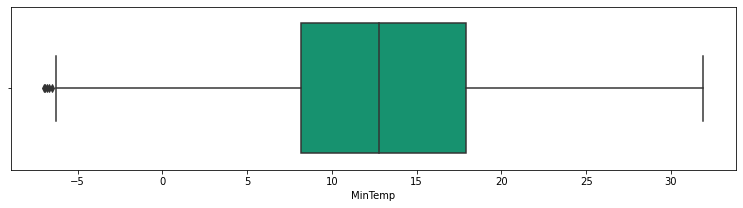

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['MinTemp'],orient='h',color='#03A678')

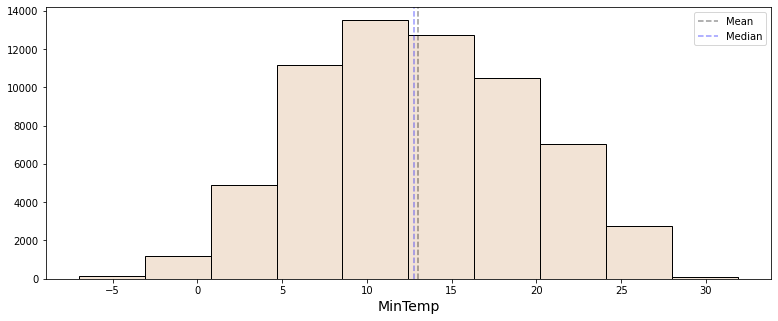

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['MinTemp'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['MinTemp'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['MinTemp'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('MinTemp', size=14)
plt.legend()

In [ ]:
# Min and max value at MinTemp column
print('Min value in MinTemp is ' + str(train_data['MinTemp'].min()))
print('Max value in MinTemp is ' + str(train_data['MinTemp'].max()))

Min value in MinTemp is -7.0
Max value in MinTemp is 31.9


In [ ]:
# MinTemp outliers
IQR = train_data.MinTemp.quantile(0.75) - train_data.MinTemp.quantile(0.25)
Lower_fence = train_data.MinTemp.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.MinTemp.quantile(0.75) + (IQR * 3)
print('MinTemp outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

MinTemp outliers are values < -20.9 or > 47.0


### **MaxTemp**

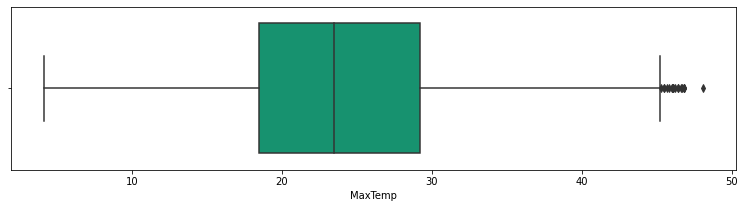

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['MaxTemp'],orient='h',color='#03A678')

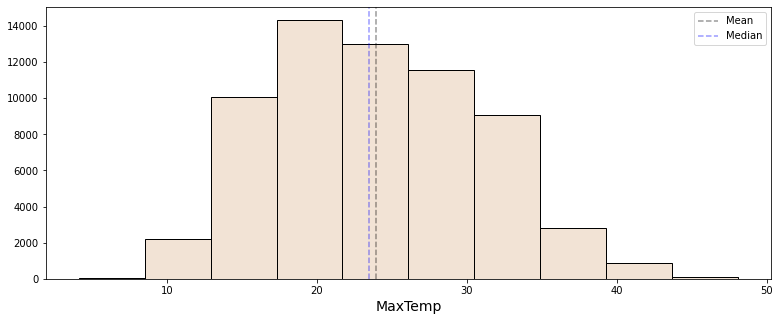

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['MaxTemp'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['MaxTemp'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['MaxTemp'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('MaxTemp', size=14)
plt.legend()

In [ ]:
# Min and max value at MaxTemp column
print('Min value in MinTemp is ' + str(train_data['MaxTemp'].min()))
print('Max value in MinTemp is ' + str(train_data['MaxTemp'].max()))

Min value in MinTemp is 4.1
Max value in MinTemp is 48.1


In [ ]:
# MaxTemp outliers
IQR = train_data.MaxTemp.quantile(0.75) - train_data.MaxTemp.quantile(0.25)
Lower_fence = train_data.MaxTemp.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.MaxTemp.quantile(0.75) + (IQR * 3)
print('MaxTemp outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

MaxTemp outliers are values < -13.599999999999994 or > 61.3


### **Rainfall**

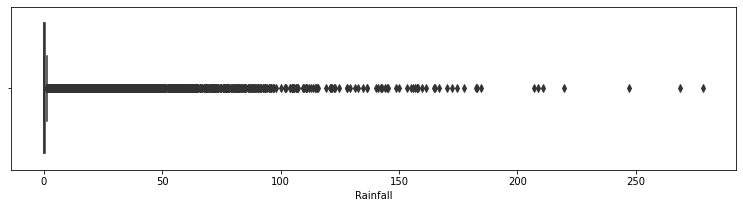

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['Rainfall'],orient='h',color='#03A678')

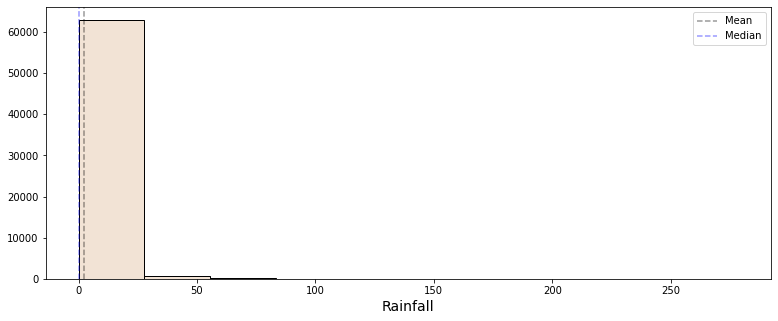

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['Rainfall'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['Rainfall'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['Rainfall'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('Rainfall', size=14)
plt.legend()

In [ ]:
# Min and max value at Rainfall column
print('Min value in Rainfall is ' + str(train_data['Rainfall'].min()))
print('Max value in Rainfall is ' + str(train_data['Rainfall'].max()))

Min value in Rainfall is 0.0
Max value in Rainfall is 278.4


In [ ]:
# Rainfall outliers
IQR = train_data.Rainfall.quantile(0.75) - train_data.Rainfall.quantile(0.25)
Lower_fence = train_data.Rainfall.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.Rainfall.quantile(0.75) + (IQR * 3)
print('Rainfall outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Rainfall outliers are values < -1.7999999999999998 or > 2.4


### **Evaporation**

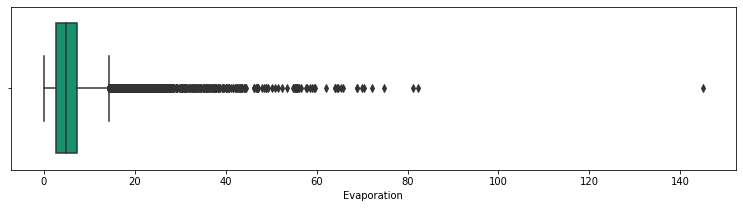

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['Evaporation'],orient='h',color='#03A678')

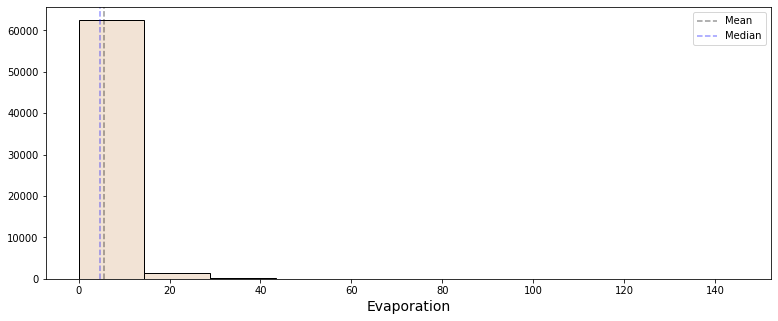

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['Evaporation'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['Evaporation'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['Evaporation'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('Evaporation', size=14)
plt.legend()

In [ ]:
# Min and max value at Evaporation column
print('Min value in Evaporation is ' + str(train_data['Evaporation'].min()))
print('Max value in Evaporation is ' + str(train_data['Evaporation'].max()))

Min value in Evaporation is 0.0
Max value in Evaporation is 145.0


In [ ]:
# Evaporation outliers
IQR = train_data.Evaporation.quantile(0.75) - train_data.Evaporation.quantile(0.25)
Lower_fence = train_data.Evaporation.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.Evaporation.quantile(0.75) + (IQR * 3)
print('Evaporation outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Evaporation outliers are values < -11.0 or > 21.200000000000003


### **Sunshine**

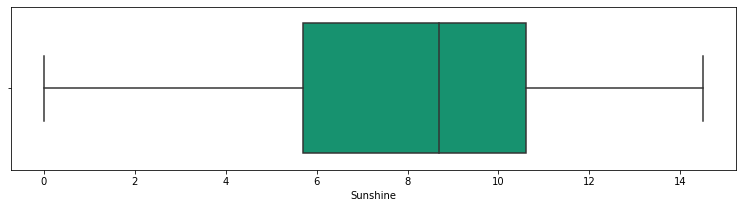

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['Sunshine'],orient='h',color='#03A678')

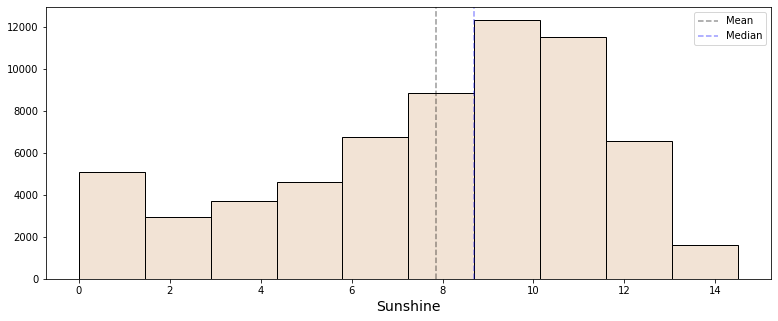

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['Sunshine'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['Sunshine'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['Sunshine'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('Sunshine', size=14)
plt.legend()

In [ ]:
# Min and max value at Sunshine column
print('Min value in Sunshine is ' + str(train_data['Sunshine'].min()))
print('Max value in Sunshine is ' + str(train_data['Sunshine'].max()))

Min value in Sunshine is 0.0
Max value in Sunshine is 14.5


In [ ]:
# Sunshine outliers
IQR = train_data.Sunshine.quantile(0.75) - train_data.Sunshine.quantile(0.25)
Lower_fence = train_data.Sunshine.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.Sunshine.quantile(0.75) + (IQR * 3)
print('Sunshine outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Sunshine outliers are values < -9.0 or > 25.299999999999997


### **WindGustSpeed**

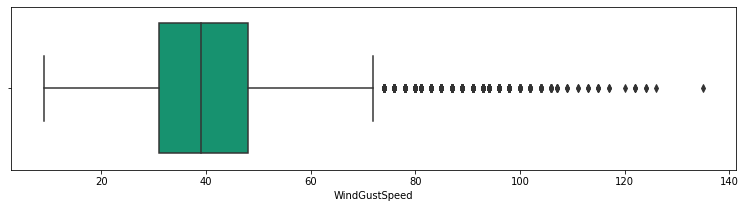

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['WindGustSpeed'],orient='h',color='#03A678')

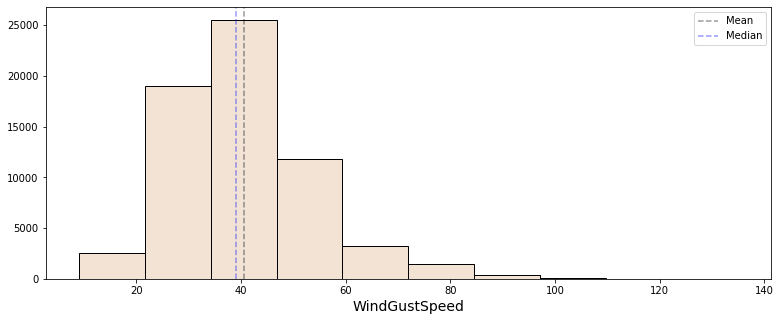

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['WindGustSpeed'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['WindGustSpeed'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['WindGustSpeed'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('WindGustSpeed', size=14)
plt.legend()

In [ ]:
# Min and max value at WindGustSpeed column
print('Min value in WindGustSpeed is ' + str(train_data['WindGustSpeed'].min()))
print('Max value in WindGustSpeed is ' + str(train_data['WindGustSpeed'].max()))

Min value in WindGustSpeed is 9.0
Max value in WindGustSpeed is 135.0


In [ ]:
# WindGustSpeed outliers
IQR = train_data.WindGustSpeed.quantile(0.75) - train_data.WindGustSpeed.quantile(0.25)
Lower_fence = train_data.WindGustSpeed.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.WindGustSpeed.quantile(0.75) + (IQR * 3)
print('WindGustSpeed outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

WindGustSpeed outliers are values < -20.0 or > 99.0


### **WindSpeed9am**

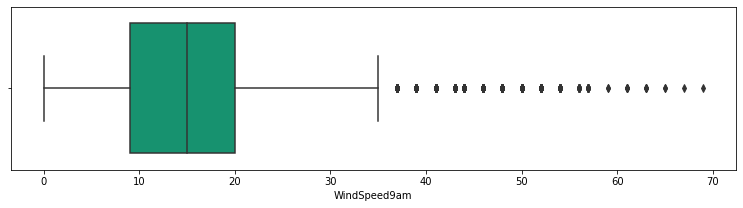

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['WindSpeed9am'],orient='h',color='#03A678')

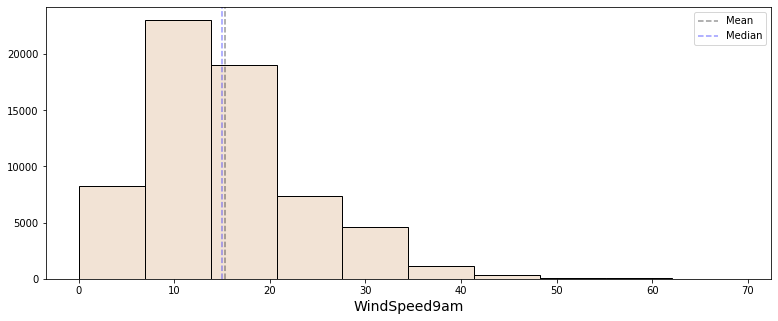

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['WindSpeed9am'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['WindSpeed9am'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['WindSpeed9am'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('WindSpeed9am', size=14)
plt.legend()

In [ ]:
# Min and max value at WindSpeed9am column
print('Min value in WindSpeed9am is ' + str(train_data['WindSpeed9am'].min()))
print('Max value in WindSpeed9am is ' + str(train_data['WindSpeed9am'].max()))

Min value in WindSpeed9am is 0.0
Max value in WindSpeed9am is 69.0


In [ ]:
# WindSpeed9am outliers
IQR = train_data.WindSpeed9am.quantile(0.75) - train_data.WindSpeed9am.quantile(0.25)
Lower_fence = train_data.WindSpeed9am.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.WindSpeed9am.quantile(0.75) + (IQR * 3)
print('WindSpeed9am outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

WindSpeed9am outliers are values < -24.0 or > 53.0


### **WindSpeed3pm**

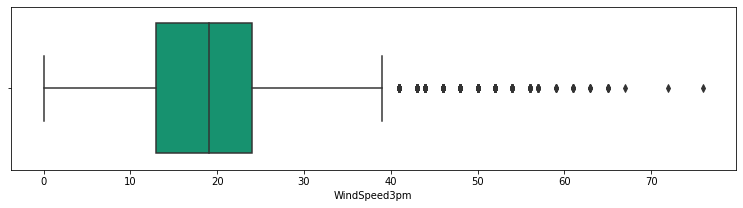

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['WindSpeed3pm'],orient='h',color='#03A678')

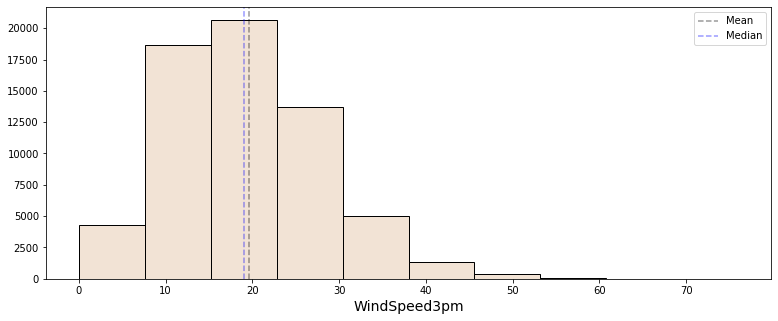

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['WindSpeed3pm'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['WindSpeed3pm'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['WindSpeed3pm'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('WindSpeed3pm', size=14)
plt.legend()

In [ ]:
# Min and max value at WindSpeed3pm column
print('Min value in WindSpeed3pm is ' + str(train_data['WindSpeed3pm'].min()))
print('Max value in WindSpeed3pm is ' + str(train_data['WindSpeed3pm'].max()))

Min value in WindSpeed3pm is 0.0
Max value in WindSpeed3pm is 76.0


In [ ]:
# WindSpeed3pm outliers
IQR = train_data.WindSpeed3pm.quantile(0.75) - train_data.WindSpeed3pm.quantile(0.25)
Lower_fence = train_data.WindSpeed3pm.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.WindSpeed3pm.quantile(0.75) + (IQR * 3)
print('WindSpeed3pm outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

WindSpeed3pm outliers are values < -20.0 or > 57.0


### **Humidity9am**

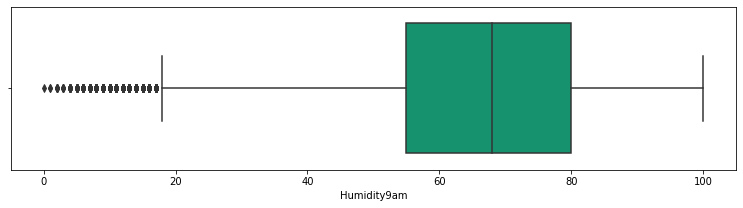

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['Humidity9am'],orient='h',color='#03A678')

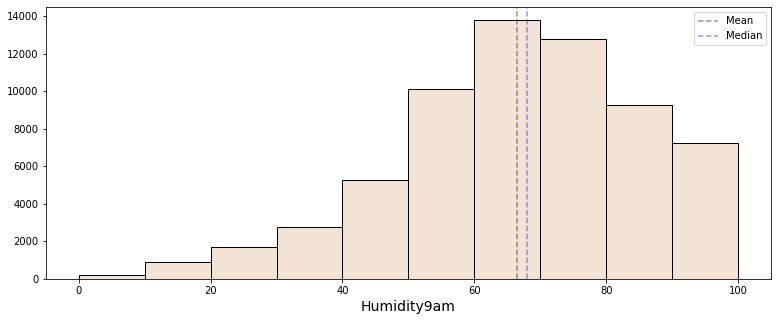

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['Humidity9am'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['Humidity9am'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['Humidity9am'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('Humidity9am', size=14)
plt.legend()

In [ ]:
# Min and max value at Humidity9am column
print('Min value in Humidity9am is ' + str(train_data['Humidity9am'].min()))
print('Max value in Humidity9am is ' + str(train_data['Humidity9am'].max()))

Min value in Humidity9am is 0.0
Max value in Humidity9am is 100.0


In [ ]:
# Humidity9am outliers
IQR = train_data.Humidity9am.quantile(0.75) - train_data.Humidity9am.quantile(0.25)
Lower_fence = train_data.Humidity9am.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.Humidity9am.quantile(0.75) + (IQR * 3)
print('Humidity9am outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Humidity9am outliers are values < -20.0 or > 155.0


### **Humidity3pm**

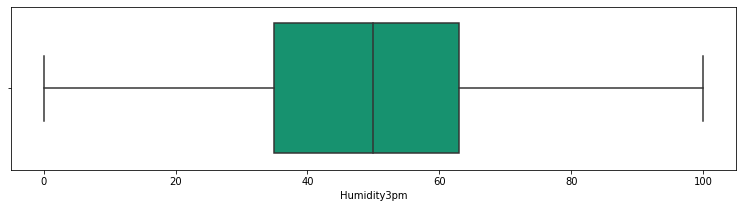

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['Humidity3pm'],orient='h',color='#03A678')

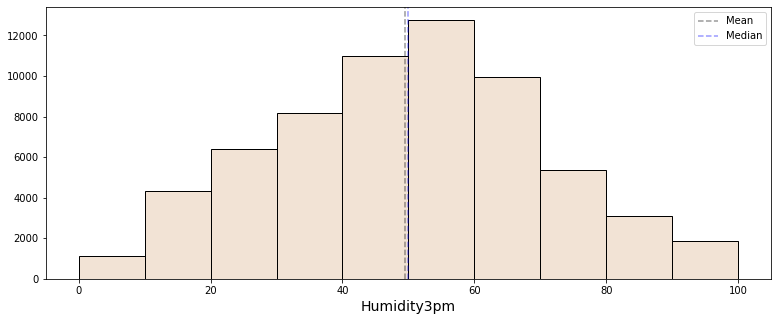

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['Humidity3pm'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['Humidity3pm'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['Humidity3pm'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('Humidity3pm', size=14)
plt.legend()

In [ ]:
# Min and max value at Humidity3pm column
print('Min value in Humidity3pm is ' + str(train_data['Humidity3pm'].min()))
print('Max value in Humidity3pm is ' + str(train_data['Humidity3pm'].max()))

Min value in Humidity3pm is 0.0
Max value in Humidity3pm is 100.0


In [ ]:
# Humidity3pm outliers
IQR = train_data.Humidity3pm.quantile(0.75) - train_data.Humidity3pm.quantile(0.25)
Lower_fence = train_data.Humidity3pm.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.Humidity3pm.quantile(0.75) + (IQR * 3)
print('Humidity3pm outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Humidity3pm outliers are values < -49.0 or > 147.0


### **Pressure9am**

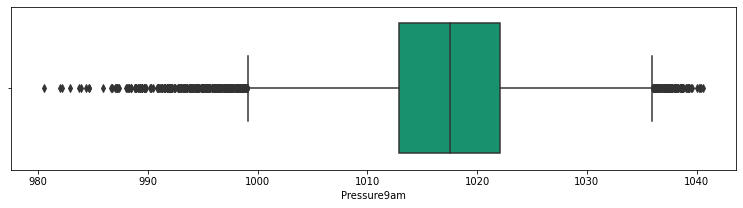

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['Pressure9am'],orient='h',color='#03A678')

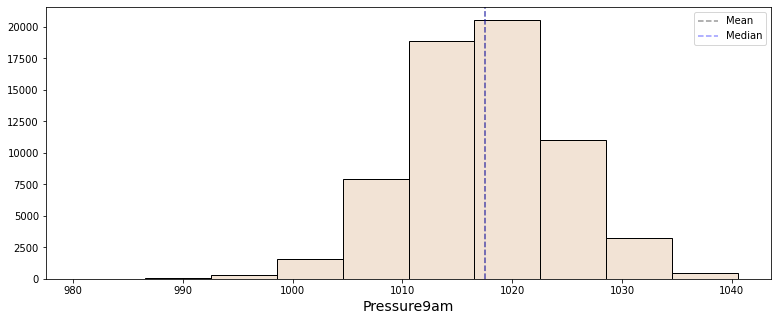

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['Pressure9am'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['Pressure9am'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['Pressure9am'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('Pressure9am', size=14)
plt.legend()

In [ ]:
# Min and max value at Pressure9am column
print('Min value in Pressure9am is ' + str(train_data['Pressure9am'].min()))
print('Max value in Pressure9am is ' + str(train_data['Pressure9am'].max()))

Min value in Pressure9am is 980.5
Max value in Pressure9am is 1040.6


In [ ]:
# Pressure9am outliers
IQR = train_data.Pressure9am.quantile(0.75) - train_data.Pressure9am.quantile(0.25)
Lower_fence = train_data.Pressure9am.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.Pressure9am.quantile(0.75) + (IQR * 3)
print('Pressure9am outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Pressure9am outliers are values < 985.2999999999998 or > 1049.7000000000003


### **Pressure3pm**

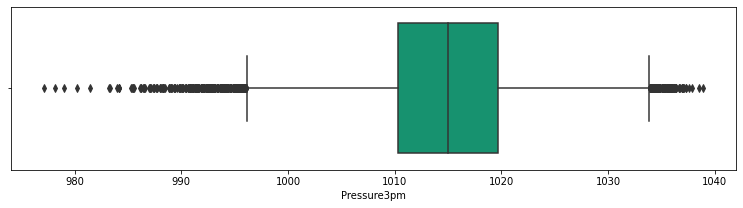

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['Pressure3pm'],orient='h',color='#03A678')

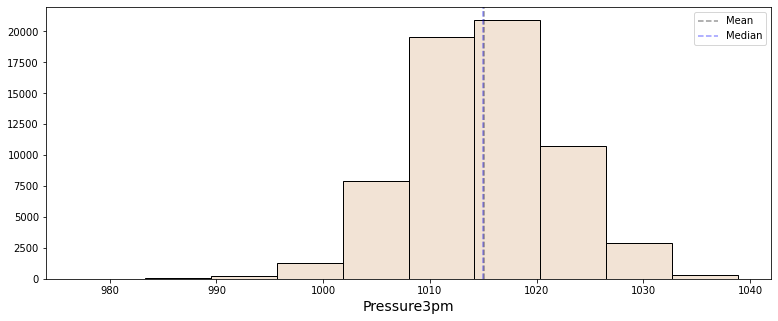

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['Pressure3pm'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['Pressure3pm'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['Pressure3pm'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('Pressure3pm', size=14)
plt.legend()

In [ ]:
# Min and max value at Pressure3pm column
print('Min value in Pressure3pm is ' + str(train_data['Pressure3pm'].min()))
print('Max value in Pressure3pm is ' + str(train_data['Pressure3pm'].max()))

Min value in Pressure3pm is 977.1
Max value in Pressure3pm is 1038.9


In [ ]:
# Pressure3pm outliers
IQR = train_data.Pressure3pm.quantile(0.75) - train_data.Pressure3pm.quantile(0.25)
Lower_fence = train_data.Pressure3pm.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.Pressure3pm.quantile(0.75) + (IQR * 3)
print('Pressure3pm outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Pressure3pm outliers are values < 982.0999999999997 or > 1047.9000000000003


### **Temp9am**

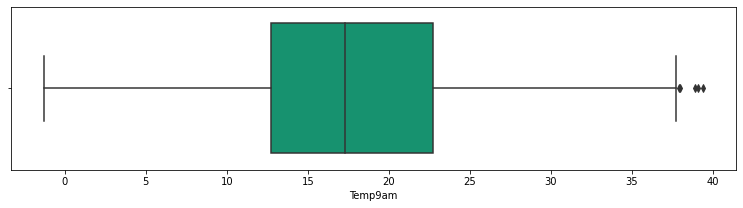

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['Temp9am'],orient='h',color='#03A678')

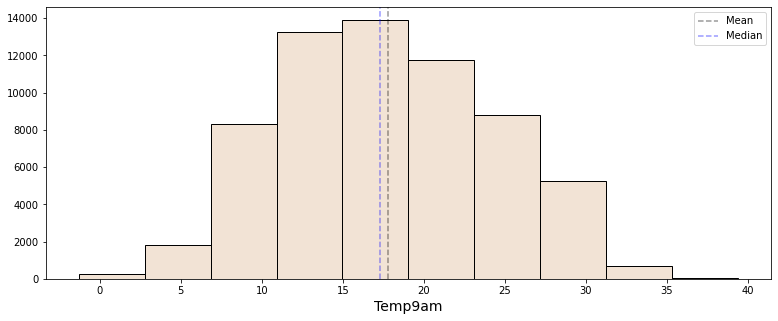

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['Temp9am'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['Temp9am'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['Temp9am'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('Temp9am', size=14)
plt.legend()

In [ ]:
# Min and max value at Temp9am column
print('Min value in Temp9am is ' + str(train_data['Temp9am'].min()))
print('Max value in Temp9am is ' + str(train_data['Temp9am'].max()))

Min value in Temp9am is -1.3
Max value in Temp9am is 39.4


In [ ]:
# Temp9am outliers
IQR = train_data.Temp9am.quantile(0.75) - train_data.Temp9am.quantile(0.25)
Lower_fence = train_data.Temp9am.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.Temp9am.quantile(0.75) + (IQR * 3)
print('Temp9am outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Temp9am outliers are values < -17.3 or > 52.7


### **Temp3pm**

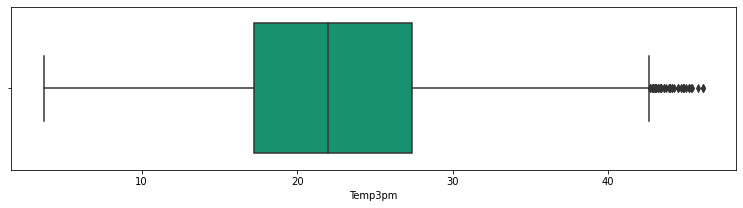

In [ ]:
# Boxplot
plt.figure(figsize=(13, 3))
sns.boxplot(train_data['Temp3pm'],orient='h',color='#03A678')

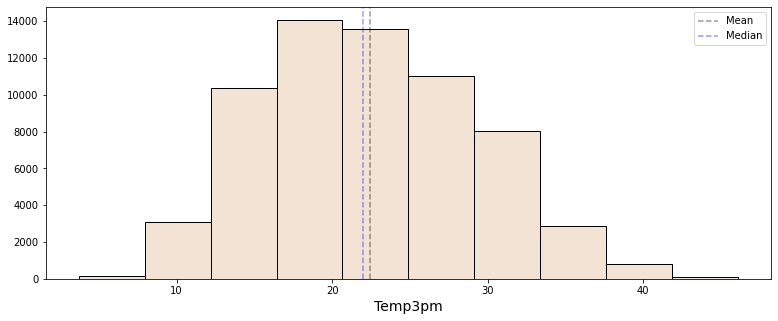

In [ ]:
# KDE Plot
fig = plt.figure(figsize=(13,5))
plt.hist(train_data['Temp3pm'], color='#F2E3D5', edgecolor = 'Black')
plt.axvline(x=train_data['Temp3pm'].mean(),ls='--',color='black',alpha=0.4,label='Mean')
plt.axvline(x=train_data['Temp3pm'].median(),ls='--',color='blue',alpha=0.4,label='Median')
plt.xlabel('Temp3pm', size=14)
plt.legend()

In [ ]:
# Min and max value at Temp3pm column
print('Min value in Temp3pm is ' + str(train_data['Temp3pm'].min()))
print('Max value in Temp3pm is ' + str(train_data['Temp3pm'].max()))

Min value in Temp3pm is 3.7
Max value in Temp3pm is 46.1


In [ ]:
# Temp3pm outliers
IQR = train_data.Temp3pm.quantile(0.75) - train_data.Temp3pm.quantile(0.25)
Lower_fence = train_data.Temp3pm.quantile(0.25) - (IQR * 3)
Upper_fence = train_data.Temp3pm.quantile(0.75) + (IQR * 3)
print('Temp3pm outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Temp3pm outliers are values < -13.399999999999999 or > 58.0


## **Bivariate Analysis & Multivariate Analysis**

In [ ]:
# Change target to binary numeric in train and test data
train_data['RainTomorrow'] = train_data['RainTomorrow'].apply(lambda x: 1 if x=='Yes' else 0).astype(int)
test_data['RainTomorrow'] = test_data['RainTomorrow'].apply(lambda x: 1 if x=='Yes' else 0).astype(int)

### **Bivariate Analysis**

Questions
1. What year does it rain the most?
2. What direction of wind gust will cause rain in the next day?
3. What cloud at 9am and 3pm which cause rain in the next day?
4. What location often experiences rain?
5. What month does it rain the most and data distribution for rainfall amount at the most rain experiences location?

In [ ]:
# Year with the most experiences rain
Year_count = train_data[train_data['RainTomorrow']==1]
Year_count = (train_data
            .groupby('Year')
            .agg(Rain_Weather=('RainTomorrow','sum'))
            .reset_index()
            .sort_values('Year',ascending=True))

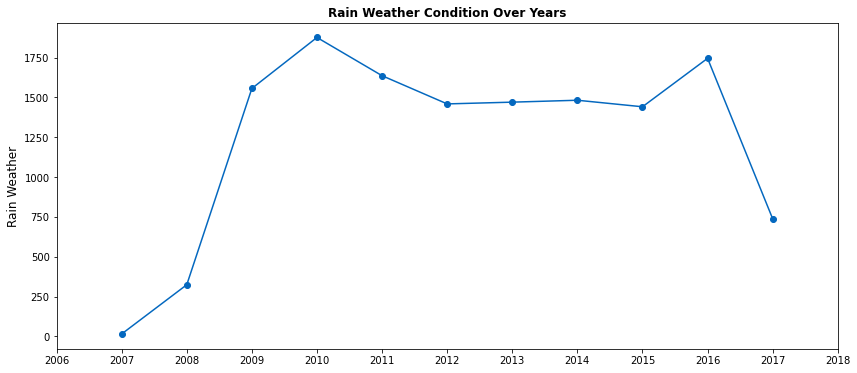

In [ ]:
year = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]
plt.figure(figsize= (14,6))
plt.plot(Year_count['Year'], Year_count['Rain_Weather'], color='#0468BF', marker='o')
plt.title('Rain Weather Condition Over Years', fontsize=12, fontweight='bold')

plt.xlim(2007,2017)

plt.ylabel('Rain Weather', fontsize=12)
plt.xticks(year)
plt.show()

In [ ]:
# Which wind gust direction that tend to cause rain in the next day
wind_dir = (train_data[train_data['RainTomorrow']==1])['WindGustDir'].value_counts()

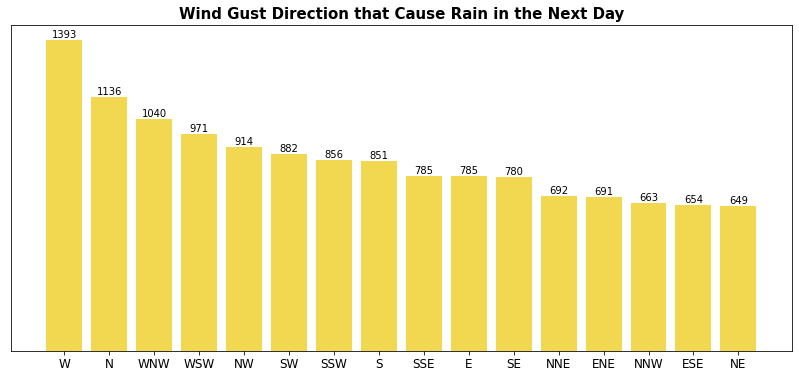

In [ ]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot()

# plot the data using matplotlib
ax.bar(wind_dir.index, wind_dir.values, color='#F2D750')

for i, (k, v) in enumerate(wind_dir.items()):
    ax.text(k, 
            v + 25, 
            v,
            fontsize=10,
            horizontalalignment='center',
            verticalalignment='center'
           )

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.set_title('Wind Gust Direction that Cause Rain in the Next Day', fontsize=15, fontweight='bold')
ax.get_yaxis().set_visible(False)

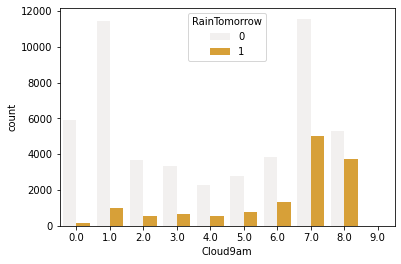

In [ ]:
# Barplot Cloud9am
sns.countplot(x='Cloud9am',hue='RainTomorrow',data=train_data,color="#F2A81D")

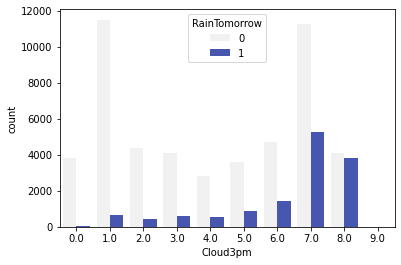

In [ ]:
# Barplot Cloud3pm
sns.countplot(x='Cloud3pm',hue='RainTomorrow',data=train_data,color="#364ABF")

In [ ]:
# Location with the most experience rain
loc_count = (train_data[train_data['RainTomorrow']==1])['Location'].value_counts().head(10)

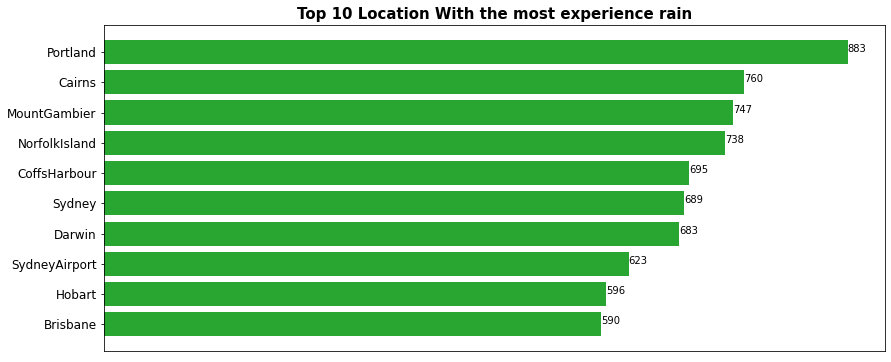

In [ ]:
value_count = loc_count.sort_values()

# Vertical bar chart
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot()

plt.barh(value_count.index, value_count.values, color='#29A632')

for index, value in enumerate(value_count.values):
    plt.text(value, index, str(value))

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.set_title('Top 10 Location With the most experience rain', fontsize=15, fontweight='bold');
ax.get_xaxis().set_visible(False)

In [ ]:
# Top 10 location experiences least rainfall?
count_loc = (train_data[train_data['RainTomorrow']==0])['Location'].value_counts().head(10)

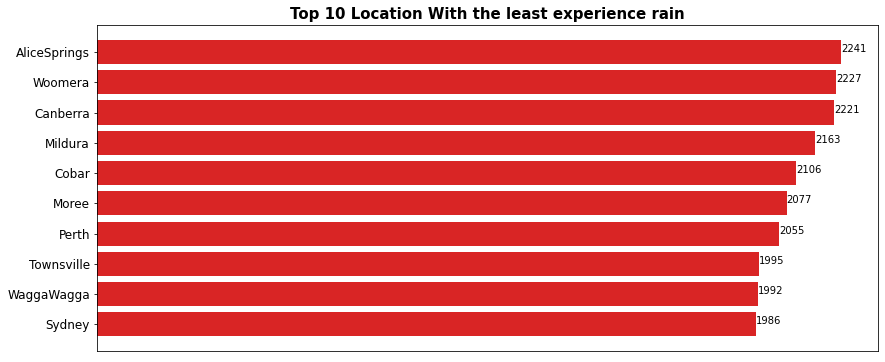

In [ ]:
value_count = count_loc.sort_values()
# Vertical bar chart
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot()

# plot the data using matplotlib
plt.barh(value_count.index, value_count.values, color='#D92525')

for index, value in enumerate(value_count.values):
    plt.text(value, index, str(value))

# size of the x and y ticks
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# set a title for the plot
ax.set_title('Top 10 Location With the least experience rain', fontsize=15, fontweight='bold');
ax.get_xaxis().set_visible(False)

In [ ]:
# What Month in Portland with the most rain experiences
Port_Rain = ((train_data[(train_data['Location']=='Portland')&(train_data['RainTomorrow']==1)])
            .groupby('Month')
            .agg(Rain_Weather=('RainTomorrow','sum'))
            .reset_index()
            .sort_values('Month',ascending=True))

# Change to month name
Port_Rain['Month'] = pd.to_datetime(Port_Rain['Month'], format='%m').dt.month_name().str.slice(stop=3)

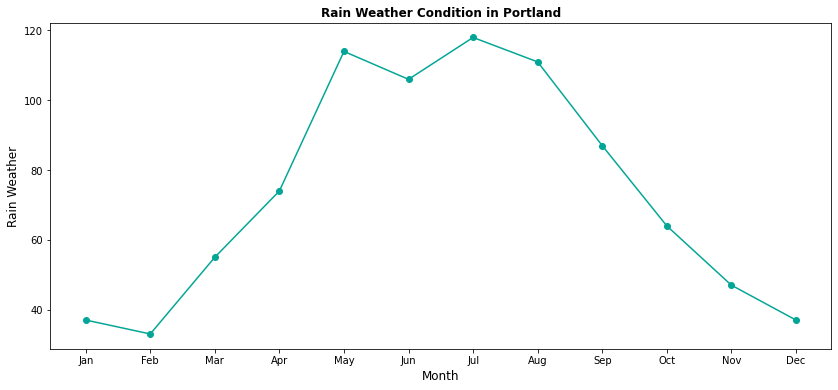

In [ ]:
plt.figure(figsize= (14,6))
plt.plot(Port_Rain['Month'], Port_Rain['Rain_Weather'], color='#03A696', marker='o')
plt.title('Rain Weather Condition in Portland', fontsize=12, fontweight='bold')

plt.xlabel('Month', fontsize=12)
plt.ylabel('Rain Weather', fontsize=12)
plt.show()

In [ ]:
# Rainfall in Portland
Port_data = train_data[train_data['Location']=='Portland']

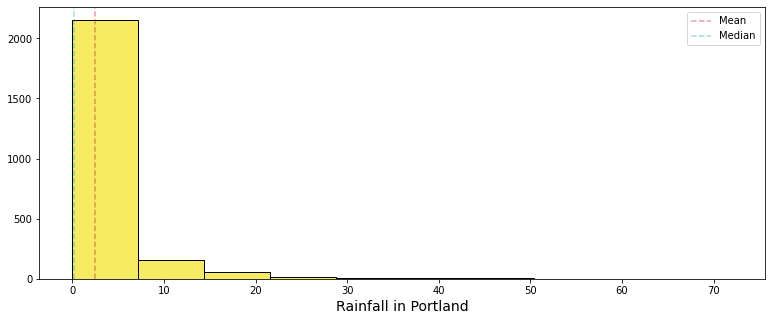

In [ ]:
# KDE Plot in Portland
fig = plt.figure(figsize=(13,5))
plt.hist(Port_data['Rainfall'], color='#F6EB61', edgecolor = 'Black')
plt.axvline(x=Port_data['Rainfall'].mean(),ls='--',color='#C8102E',alpha=0.4,label='Mean')
plt.axvline(x=Port_data['Rainfall'].median(),ls='--',color='#00B2A9',alpha=0.4,label='Median')
plt.xlabel('Rainfall in Portland', size=14)
plt.legend()

In [ ]:
# Summary amount rainfall in Portland
Port_data['Rainfall'].describe()

count    2404.000000
mean        2.486855
std         5.547385
min         0.000000
25%         0.000000
50%         0.200000
75%         2.600000
max        72.000000
Name: Rainfall, dtype: float64

- 2010 and 2016 become the year with the highest frequency of rain in Australia.
- When the wind gust direction in Australia happen between West to North, rain in the next day tend to happen.
- Sky in Australia mostly cloudy. Rain in the next day tend to happen when cloud in 9am and 3pm is 7 or 8 oktas.
- Portland is the location in Australia that experiences the most rain. Meanwhile Alice Springs become the location with least experiences rain.
- Rain in Portland is most common to happen from May to August. We can conclude that these period is the rainy season in Portland.
- Rainfall distribution in Portland is positively skew, with majority amount of rainfall in Portland aroud 0 - 8 mm.

### **Multivariate Analysis**

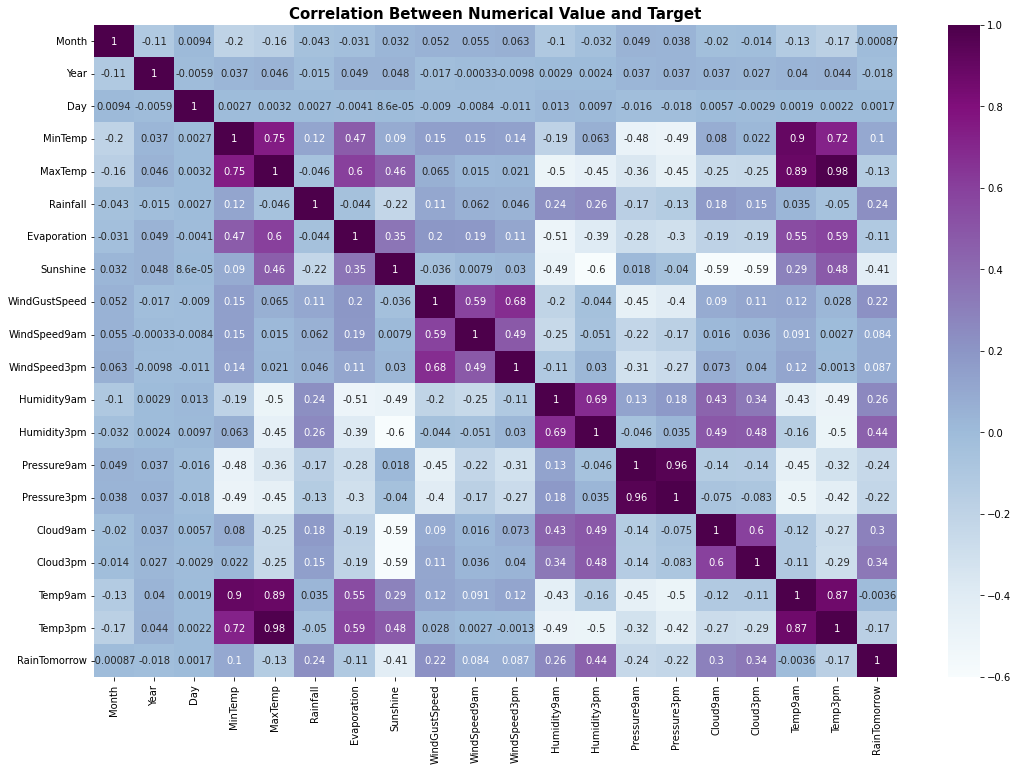

In [ ]:
# Heatmap for the correlation data
correlation = train_data.corr()

plt.figure(figsize = (18, 12))
sns.heatmap(correlation, annot=True, cmap='BuPu')
plt.title('Correlation Between Numerical Value and Target', fontsize=15, fontweight='bold')
plt.show()

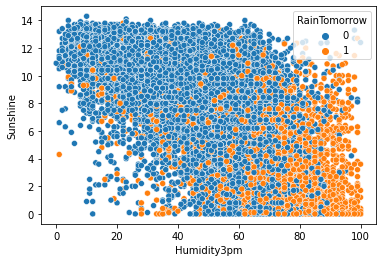

In [ ]:
# Scatterplot between Humidity3pm and Sunshine
sns.scatterplot(data=test_data, x='Humidity3pm', y='Sunshine', hue='RainTomorrow')

- `Humidity3pm` (Positive) and `Sunshine` (Negative) features have the highest correlation with target.
- `Pressure9am` and `Pressure3pm` then `MinTemp`, `MaxTemp`, `Temp9am`, and `Temp3pm` have high correlate each other.`Pressure9am` and `Temp3pm` have higher correlation with target.
- When `Humidity3pm` ratio is high and number of hours of bright `Sunshine` is low, rain in the next day tend to happen.


# **Feature Engineering**

## **Outlier Handling**

Based on outlier check, outliers at `Rainfall`, `Evaporation`, `WindGustSpeed`, `WindSped9am`, `WindSpeed3pm`, `Pressure9am`, and `Pressure3pm`.


In [ ]:
# Remove outliers based on max value
def max_value(df1, variable, top):
    return np.where(df1[variable]>top, top, df1[variable])

for df1 in [train_data, test_data]:
  df1['Rainfall'] = max_value(df1, 'Rainfall', 2.4)
  df1['Evaporation'] = max_value(df1, 'Evaporation', 21.200000000000003)
  df1['WindGustSpeed'] = max_value(df1, 'WindGustSpeed', 99.0)
  df1['WindSpeed9am'] = max_value(df1, 'WindSpeed9am', 53.0)
  df1['WindSpeed3pm'] = max_value(df1, 'WindSpeed3pm', 57.0)

In [ ]:
# Remove outliers based on min value
def min_value(df2, variable, low):
    return np.where(df2[variable]<low, low, df2[variable])

for df2 in [train_data, test_data]:
  df2['Pressure9am'] = min_value(df2, 'Pressure9am', 985.2999999999998)
  df2['Pressure3pm'] = min_value(df2, 'Pressure3pm', 982.0999999999997)


## **Categorical Data Handling**

For handling category data, I will treat the each categorical data differently:
- Label Encoding for column with 2 distinct values [`RainToday`]
- One Hot Encoding for column with more than 2 distinct values [`Location`]
- One Hot Encoding with top 10 most frequently appearing for column with more than 10 distinct values [`WindGustDir`, `WindDir9am`, `WindDir3pm`]

In [ ]:
# Handling column with 2 distinct value
train_data['RainToday'] = train_data['RainToday'].apply(lambda x: 1 if x=='Yes' else 0).astype(int)

In [ ]:
# Handling column with more than 2 distinct value
train_data = pd.get_dummies(train_data)

In [ ]:
train_data.head(3)

Month  Year  Day  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0      1  2014   20     22.4     31.2       0.6          0.8       1.6   
1      1  2010   26     21.3     40.6       0.0         13.4      12.8   
2      1  2017   13     27.2     37.4       0.0         11.6      12.0   

   WindGustSpeed  WindSpeed9am  ...  WindDir3pm_NNW  WindDir3pm_NW  \
0           30.0           4.0  ...               0              0   
1           43.0           9.0  ...               0              0   
2           56.0          20.0  ...               0              1   

   WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  WindDir3pm_SW  \
0             0              0               0               0              0   
1             0              0               0               0              0   
2             0              0               0               0              0   

   WindDir3pm_W  WindDir3pm_WNW  WindDir3pm_WSW  
0             0               0               0  
1             0               0               0  
2             0               0               0  

[3 rows x 95 columns]

## **Drop Feature**

I will drop `Pressure3pm`, `MinTemp`, `MaxTemp`, and `Temp9am` because high correlate feature. Also I will drop feature `Year` because I think feature will not be used for modelling.

In [ ]:
train_data = train_data.drop(columns = ['Pressure3pm', 'MinTemp', 'MaxTemp', 'Temp9am', 'Year'])

## **Resampling**

In [ ]:
# Quantity RainTomorrow column
train_data['RainTomorrow'].value_counts()

0    50290
1    13742
Name: RainTomorrow, dtype: int64

Since the data is imbalance and large enough, I will do undersampling.

In [ ]:
# Split train data become x and y
x_train = train_data.drop(columns='RainTomorrow')
y_train = train_data['RainTomorrow']

In [ ]:
# Undersampling data train
x_train, y_train = under_sampling.RandomUnderSampler().fit_resample(x_train, y_train)

In [ ]:
# Insanity check
y_train.value_counts()

0    13742
1    13742
Name: RainTomorrow, dtype: int64

Now data train already balance.

## **Scaling**

In [ ]:
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)

## **Test Data Processing**

Test data will treated like train data.

In [ ]:
test_data.head(3)

Location  Month  Year  Day  MinTemp  MaxTemp  Rainfall  Evaporation  \
0  AliceSprings      1  2015   14     21.4     31.3       0.0          7.2   
1  AliceSprings      1  2013   31     14.9     36.3       0.0         12.0   
2  AliceSprings      1  2009   16     25.7     37.5       0.0         21.2   

   Sunshine WindGustDir  ...  Humidity9am Humidity3pm Pressure9am  \
0      11.3          SE  ...         48.0        29.0      1009.6   
1      13.0          SW  ...         13.0         6.0      1013.6   
2      12.6         ESE  ...         15.0        14.0      1012.6   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0       1007.3       5.0       3.0     25.2     29.9         No             0  
1       1010.1       0.0       0.0     28.1     35.4         No             1  
2       1009.0       1.0       2.0     30.1     37.5         No             0  

[3 rows x 25 columns]

In [ ]:
# Handling column with 2 distinct value
test_data['RainToday'] = test_data['RainToday'].apply(lambda x: 1 if x=='Yes' else 0).astype(int)

In [ ]:
# Handling column with more than 2 distinct value
test_data = pd.get_dummies(test_data)

In [ ]:
test_data.head(3)

Month  Year  Day  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0      1  2015   14     21.4     31.3       0.0          7.2      11.3   
1      1  2013   31     14.9     36.3       0.0         12.0      13.0   
2      1  2009   16     25.7     37.5       0.0         21.2      12.6   

   WindGustSpeed  WindSpeed9am  ...  WindDir3pm_NNW  WindDir3pm_NW  \
0           35.0          15.0  ...               0              0   
1           48.0          15.0  ...               0              0   
2           56.0          30.0  ...               0              0   

   WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  WindDir3pm_SW  \
0             1              0               0               0              0   
1             0              0               0               1              0   
2             0              0               0               0              0   

   WindDir3pm_W  WindDir3pm_WNW  WindDir3pm_WSW  
0             0               0               0  
1             0               0               0  
2             0               0               0  

[3 rows x 95 columns]

In [ ]:
# Drop feature
test_data = test_data.drop(columns = ['Pressure3pm', 'MinTemp', 'MaxTemp', 'Temp9am', 'Year'])

In [ ]:
# Split test data become x and y
x_test = test_data.drop(columns='RainTomorrow')
y_test = test_data['RainTomorrow']

In [ ]:
scaler = MinMaxScaler()
scaler.fit(x_test)

x_test_scaled = scaler.transform(x_test)

# **Modelling and Evaluation**

After some preprocessing data, I will re-create model with same algorithms with baseline. Since the data is imbalance, I will use AUC as evaluation metric.

In [ ]:
models = [KNeighborsClassifier(),
          LogisticRegression(random_state=42),
          DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(random_state=42),
          XGBClassifier(random_state=42)]

df_model = pd.DataFrame(columns = ['Model', 'ROC_AUC'])

In [ ]:
for model in models:
  model.fit(x_train_scaled, y_train)
  y_pred = model.predict(x_test_scaled)

  model = str(type(model)).split('.')[-1][:-2]

  # ROC AUC
  roc_auc = roc_auc_score(y_test, y_pred)

  df_model = df_model.append({'Model': model,
                    'ROC_AUC': roc_auc},
                     ignore_index=True)

In [ ]:
df_model

Model   ROC_AUC
0    KNeighborsClassifier  0.715302
1      LogisticRegression  0.794292
2  DecisionTreeClassifier  0.706396
3  RandomForestClassifier  0.798784
4           XGBClassifier  0.793817

## **AUC Each Model**

In [ ]:
# Retrieve KNN model
knn = KNeighborsClassifier()
knn.fit(x_train_scaled, y_train)

KNeighborsClassifier()

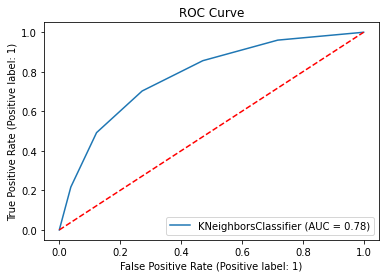

In [ ]:
# Create ROC curve
metrics.plot_roc_curve(knn, x_test_scaled, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [ ]:
# Retrieve Logistic Regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(x_train_scaled, y_train)

LogisticRegression(random_state=42)

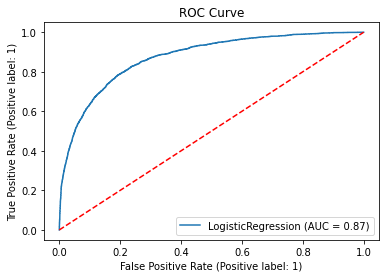

In [ ]:
# Create ROC curve
metrics.plot_roc_curve(logreg, x_test_scaled, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [ ]:
# Retrieve Decision Tree classifier model
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(x_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

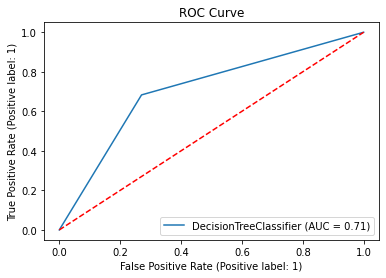

In [ ]:
# Create ROC curve
metrics.plot_roc_curve(dt_clf, x_test_scaled, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [ ]:
# Retrieve Random Forest classifier model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(x_train_scaled, y_train)

RandomForestClassifier(random_state=42)

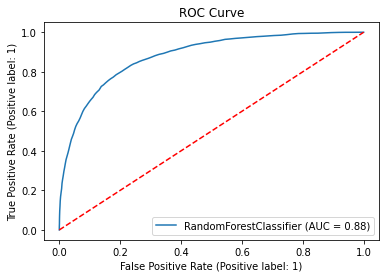

In [ ]:
# Create ROC curve
metrics.plot_roc_curve(rf_clf, x_test_scaled, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [ ]:
# Retrieve XG Boost classifier model
xgb = XGBClassifier(random_state=42)
xgb.fit(x_train_scaled, y_train)

XGBClassifier(random_state=42)

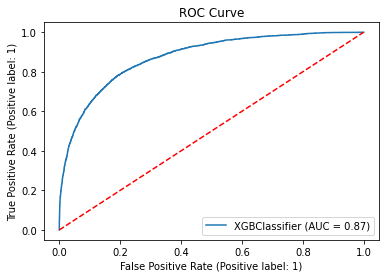

In [ ]:
# Create ROC curve
metrics.plot_roc_curve(xgb, x_test_scaled, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

# **Hyperparameter Tuning**

Random forest classifier model have the best AUC score, I will try to increase the performance by hyperparameter tuning.

In [ ]:
# Set parameter for tuning
%%time
parameters = {
    'n_estimators': (300, 400, 500, 600, 700),
    'max_depth':(30, 40, 50, 60, 70),
    'criterion':('gini', 'entropy')
    }

# Hyperparameter using GridSearchCV
rf_gridcv = GridSearchCV(rf_clf, parameters, cv=5, scoring='accuracy')
rf_gridcv.fit(x_train_scaled, y_train)

CPU times: user 1h 39min 20s, sys: 16.1 s, total: 1h 39min 37s
Wall time: 1h 40min 16s


In [ ]:
# Get the best parameters from the cross-validation method
print("Best Tuned Hyperparameters are:", rf_gridcv.best_params_)

Best Tuned Hyperparameters are: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 700}


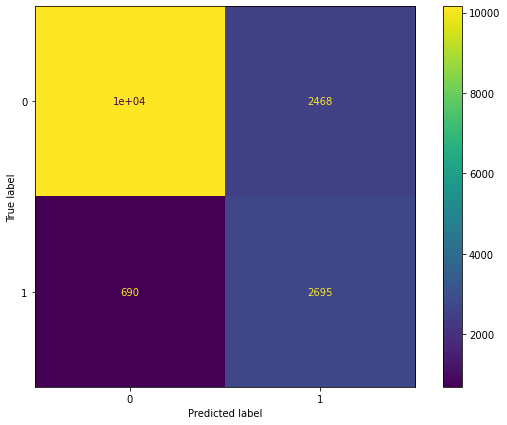

In [ ]:
# Create confusion matrix
fig, ax = plt.subplots(figsize=(10,7))
y_pred_rf = rf_gridcv.best_estimator_.predict(x_test_scaled)
cm = confusion_matrix(y_test, y_pred_rf, labels=rf_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf_gridcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

In [ ]:
# Get classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.80      0.87     12623
           1       0.52      0.80      0.63      3385

    accuracy                           0.80     16008
   macro avg       0.73      0.80      0.75     16008
weighted avg       0.85      0.80      0.82     16008



In [ ]:
# Get ROC_AUC score
print(f'ROC AUC score = {roc_auc_score(y_test,y_pred_rf)}')

ROC AUC score = 0.8003217029803396


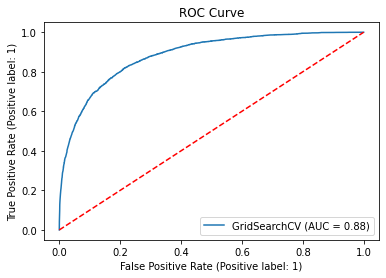

In [ ]:
# Create ROC curve
metrics.plot_roc_curve(rf_gridcv, x_test_scaled, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

# **Potential Impact in Business**

The biggest question for model of course, how big impact our model to business problems? I will do simulation based on predictive model result for business terms.

## **Example Case**

Fresh Fields Co. is a agricultural company that operated in Portland, Australia. They have their own rice field of 1000 hectares. They need water for irrigation of their fields, especially in dry season. How much cost in a month (30 days) that they can save in water supply at dry season?

**Before**

- Water needs (N) = 6,39 mm/day/ha
- Water price (P) = 0.41 AUD/m cubic (0.29 USD/m cubic)

In [1]:
# Water needs in a month
N = (6.39 * 30 * (1000 * 10000)) / 1000000 # in liter

print('Water needs for irrigation in a month is ' + str(N) + ' liter')

Water needs for irrigation in a month is 1917.0 liter


In [2]:
# Water cost in a month
P = 0.29 * 1000 # in liter
C = P * N

print('Cost for water supply in a month is ' + str(C) + ' USD')

Cost for water supply in a month is 555930.0 USD


**After**

The main idea is with our predictive model result, we can predict the weather will rain or not and can prepared to make water stock for irrigation in dry season, so, cost for water supply can be saved.

Note:
- Rainfall in Portland (R) = 2,49 mm
- True Positive Rate for model (TPR) = 80%

So based on TPR result, in 30 days, model can predict 24 days will rain.

In [3]:
# Water volume that can be stocked in a month
AR = (2.49 * 24 * (1000 * 10000)) / 1000000 # in liter

print('Water volume that can be stocked in a month is ' + str(AR) + ' liter')

Water volume that can be stocked in a month is 597.6 liter


In [4]:
# Saving water cost
s = P * AR
ratio = round(((s / C) * 100),0)

print('Cost for water supply can be saved ' + str(s) + ' USD or ' + str(ratio) + ' %')

Cost for water supply can be saved 173304.0 USD or 31.0 %


## **Feature Importances**

I will create feature importances by SHAP (**SH**apley **A**dditive ex**P**lanations) values. Its a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models.

In [ ]:
explainer = shap.TreeExplainer(rf_clf)

In [ ]:
# Calculate Shap values
choosen_instance = x_test.loc[[1]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
# Calculate Shap values
choosen_instance = x_test.loc[[157]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
# Calculate Shap values
choosen_instance = x_test.loc[[65]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
# Calculate Shap values
choosen_instance = x_test.loc[[94]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
# Calculate Shap values
choosen_instance = x_test.loc[[120]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
# Calculate Shap values
choosen_instance = x_test.loc[[43]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
# Calculate Shap values
choosen_instance = x_test.loc[[173]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
# Calculate Shap values
choosen_instance = x_test.loc[[37]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
# Calculate Shap values
choosen_instance = x_test.loc[[209]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
# Calculate Shap values
choosen_instance = x_test.loc[[345]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

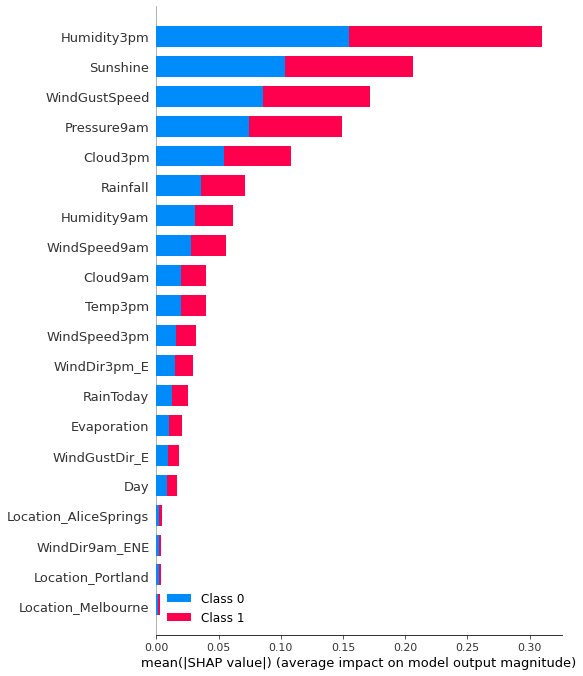

In [ ]:
shap.summary_plot(shap_values, x_train)

Feature values in pink cause to increase the prediction. Size of the bar shows the magnitude of the feature's effect. Feature values in blue cause to decrease the prediction. Based on SHAP value, `Humidity3pm` and `Sunshine` feature have the highest effect on the prediction. It’s same with heatmap correlation.

# **Conclusion**

- Based on Heatmap and SHAP values for feature importances, Humidity at 3pm and Sunshine has the big impact to cause rain in the next day.
- Random Forest classifier is the best model algorithm for predicting rain the next day because have the highest AUC score than other classifier algorithm.
- The location with the most rain frequency is Portland with rain season tend to happen in May until August.
- Based on simulation, model performance can help saving company cost for water supply by 39%.